In [1]:
from sx_multi import DataSource
from sx_multi import Analysis
from sx_multi import Accumulator
from sx_multi import DaskExecutor

import matplotlib.pyplot as plt

from servicex import ServiceXDataset
from sx_multi import FuncAdlDataset
from coffea import hist, processor

from IPython.display import update_display

In [2]:
dids = ['mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00']
datasets = [
    ServiceXDataset(did, backend_type='xaod')
    for did in dids
]

In [3]:
leptons_per_event_query = FuncAdlDataset() \
        .Select(lambda e: e.Electrons("Electrons")) \
        .Select(lambda eles: eles.Where(lambda e: e.pt()/1000.0 > 30.0)) \
        .Select(lambda eles: eles.Where(lambda e: abs(e.eta()) < 2.5)) \
        .Where(lambda eles: len(eles) == 2) \
        .Select(lambda ls: (ls.Select(lambda e: e.pt()/1000.0), ls.Select(lambda e: e.eta()), ls.Select(lambda e: e.phi()), ls.Select(lambda e: e.m()/1000.0), ls.Select(lambda e: e.charge()))) \
        .AsROOTTTree('data.root', 'mytree', ('electrons_pt', 'electrons_eta', 'electrons_phi', 'electrons_mass', 'electrons_charge'))

In [4]:
datasource = DataSource(query=leptons_per_event_query, metadata={}, datasets=datasets)

In [5]:
class Z_EEAnalysis(Analysis):
    def __init__(self):
        self.accumulator = Accumulator({
            "mass": hist.Hist(
                "Events",
                hist.Bin("mass", "$Z_{ee}$ [GeV]", 60, 60, 120),
            ),
        })

    @staticmethod
    def process(output, events):
        import awkward1 as ak

        dataset = events.metadata['dataset']
        electrons = events.electrons

        # Form the invar mass, plot.
        cut = (ak.num(electrons) == 2)
        diele = electrons[cut][:, 0] + electrons[cut][:, 1]

        output["sumw"][dataset] += len(events)
        output["mass"].fill(
            mass=diele.mass,
        )

        return output

We create the analysis and executor. The `DaskExecutor` can be done two ways:

- `DaskExecutor()` which creates a local cluster. All data will be pulled down to the local machine via an `uproot.open`. This can be paiful depending on what your connection looks like.
- `DaskExecutor(client_addr="node.name.edu:8080")` which will attach to a remote `dask` cluster. This is particularly powerful if the `dask` cluster is located close to the `servicex` installation.

In [6]:
analysis = Z_EEAnalysis()
executor = DaskExecutor()

This next method makes an updating plot, as the data appears. If you didn't want the fancy updating plot, you could do `await executor.execute(analysis, datasource)`, and you'd end up with the coffea dict when that cell completed.

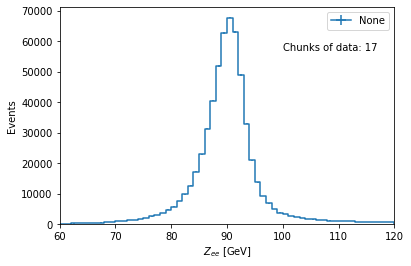

In [7]:
fig, axes = plt.subplots()
first = True

async def plot_stream(accumulator_stream):
  global first
  count = 0
  async for coffea_info in accumulator_stream:
    hist.plot1d(coffea_info['mass'], ax=axes)

    count += 1
    plt.text(0.95, 0.8, f'Chunks of data: {count}', horizontalalignment='right', transform=axes.transAxes)

    # Either display it or update a previous version of the plot
    if first:
        display(fig, display_id='mass_update')
        first = False
    else:
        update_display(fig, display_id='mass_update')
  return coffea_info

await plot_stream(executor.execute(analysis, datasource))
plt.close()  # Prevents another copy of the plot showing up in the notebook